# Stakewars Challenge 07 - Data Science for Staking

## Setup

We do some research on mainnet here and spend some NEAR for contract calls. In order to save your NEAR, we set the network to testnet here. You will have to change it to mainnet yourself.

Second, you have to set your account id here that you want to use to make the contract calls to the staking contracts.

Also, as running shell commands in Jupyter Notebooks is something I have little experience with, you have to set your nvm bin directory here so that I can find your `near-cli` installation. Thanks.

In [24]:
NEAR_ENV="testnet"
NVM_BIN_PATH="~/.nvm/versions/node/v14.19.0/bin"
ACCOUNT_ID="YOUR ACCOUNT"



## Goal definition

### Goal: check diversification of actual stakers on mainnet

In order to minimize risk, it would be expected that stakers diversify their portfolio of validators by staking their staked NEAR with different validators. If one validator performs badly the staker then only loses a part of their staking rewards. I would therefore like to check if current stakers on mainnet actually act according to this principle. 

### Expected result

My hypothesis is that stakers actually do not care a lot about risk diversification and that most of the stakers place their stake with only one validator.

### Measurement of diversification

In a first simplified approach, diversification can be measured by counting the number of validators one staker has staked with. The higher the count, the higher the diversification. A more elaborate approach would be also taking into account the actual distribution of their stake. A staker who stakes with two validators for 50% each has arguably a higher diversification than a staker who stakes with three validators but has a distribution of 90% / 5% / 5%.

## Data acquisition

Let's first get the list of current validators.

In [25]:
from subprocess import run, PIPE
from os import environ
import re

validators = []
cmd = ['near', 'validators', 'current']
result = run(cmd, stdout=PIPE, check=True, cwd=NVM_BIN_PATH, env={"PATH":".", "NEAR_ENV": NEAR_ENV})
out = result.stdout.decode('utf-8')
for line in out.splitlines():
    match = re.search("\| ((([a-z\d]+[\-_])*[a-z\d]+\.)*([a-z\d]+[\-_])*[a-z\d]+) .* \|", line)
    if match:
        validators.append(match[1])
print(validators)


['bzam6yjpnfnxsdmjf6pw.poolv1.near', 'astro-stakers.poolv1.near', 'bisontrails.poolv1.near', 'dragonfly.poolv1.near', 'zavodil.poolv1.near', 'foundry.poolv1.near', 'aurora.pool.near', 'binancenode1.poolv1.near', 'staking_yes_protocol1.poolv1.near', 'yes_protocol1.poolv1.near', 'valisaurus-dex.poolv1.near', 'stake1.poolv1.near', 'epic.poolv1.near', 'magic.poolv1.near', 'future_is_near.poolv1.near', 'finoa.poolv1.near', 'rekt.poolv1.near', 'blockdaemon.poolv1.near', 'figment.poolv1.near', 'nearcrowd.poolv1.near', '08investinwomen_runbybisontrails.poolv1.near', 'd1.poolv1.near', 'anonymous.poolv1.near', 'continue.poolv1.near', 'chorusone.poolv1.near', 'dokiacapital.poolv1.near', 'accomplice.poolv1.near', 'hb436_pool.poolv1.near', 'electric.poolv1.near', 'ideocolabventures.poolv1.near', 'stakin.poolv1.near', 'openshards.poolv1.near', 'northernlights.poolv1.near', 'nearfans.poolv1.near', 'legends.poolv1.near', 'staked.poolv1.near', 'pandora.poolv1.near', 'cryptium.poolv1.near', 'smart-stake

For every validator we now call the staking contract to first get the number of accounts staking with this validator. We then call the method to get the actual staker account ids and the corresponding stakes and save all the data into csv files, one for each validator.

In [26]:
from os import mkdir, path
import json
import csv

BATCH_SIZE=100
GAS=100_000_000_000_000
DATA_PATH="data"

def file_name(validator):
    return f'{DATA_PATH}/stakers_{validator}.csv'

if not path.isdir(DATA_PATH):
    mkdir(DATA_PATH)

# do not run this again
exit()

for validator in validators:
    print(f"Getting data for validator {validator}")
    staker_count = 0
    cmd = ['near', 'call', validator, 'get_number_of_accounts', '--accountId', ACCOUNT_ID]
    result = run(cmd, stdout=PIPE, stderr=PIPE, check=True, cwd=NVM_BIN_PATH, env={"PATH":".", "NEAR_ENV": NEAR_ENV})
    result = result.stdout.decode('utf-8')
    if result.find("Cannot find contract code for account")>= 0:
        continue
    staker_count = int(result.splitlines()[-1])
    from_index = 0
    if path.isfile(file_name(validator)):
        with open(file_name(validator), 'r', newline='') as f:
            from_index = len(f.readlines()) - 1
    while from_index <= staker_count:
        print(f"    Getting stakers from {from_index} to {from_index + BATCH_SIZE}")    
        cmd = ['near', 'call', validator, 'get_accounts', f"'{{\"from_index\":{from_index},\"limit\":{BATCH_SIZE}}}'", '--accountId', ACCOUNT_ID, '--gas', str(GAS)]
        cmd_result = run(cmd, stdout=PIPE, stderr=PIPE, check=True, cwd=NVM_BIN_PATH, env={"PATH":".", "NEAR_ENV": NEAR_ENV})
        out = cmd_result.stdout.decode('utf-8')
        header_finished = False
        result=''
        for line in out.splitlines():
            match = re.search(r"^\[", line)
            if match or header_finished:
                header_finished = True
                result +=line
        result = re.sub("([a-z_]*):","\"\\1\":",result)
        result = re.sub("'","\"",result)
        result = re.sub("balance: \"([0-9]+)\"","balance: \\1",result)
        stakers = json.loads(result)
        if len(stakers) > 0:
            with open(file_name(validator), 'a+', newline='') as f:
                writer = csv.DictWriter(f, fieldnames = stakers[0].keys())
                if from_index == 0:
                    writer.writeheader()
                writer.writerows(stakers)
        from_index += BATCH_SIZE



Getting data for validator bzam6yjpnfnxsdmjf6pw.poolv1.near
    Getting stakers from 0 to 100
    Getting stakers from 100 to 200
    Getting stakers from 200 to 300
    Getting stakers from 300 to 400
    Getting stakers from 400 to 500
Getting data for validator astro-stakers.poolv1.near
    Getting stakers from 0 to 100
    Getting stakers from 100 to 200
    Getting stakers from 200 to 300
    Getting stakers from 300 to 400
    Getting stakers from 400 to 500
    Getting stakers from 500 to 600
    Getting stakers from 600 to 700
    Getting stakers from 700 to 800
    Getting stakers from 800 to 900
    Getting stakers from 900 to 1000
    Getting stakers from 1000 to 1100
    Getting stakers from 1100 to 1200
    Getting stakers from 1200 to 1300
    Getting stakers from 1300 to 1400
    Getting stakers from 1400 to 1500
    Getting stakers from 1500 to 1600
    Getting stakers from 1600 to 1700
    Getting stakers from 1700 to 1800
    Getting stakers from 1800 to 1900
    Gett

## Data Analysis 

Now we create one dataset with all stakers, indicating for each how many validators they are staking with. Loop through all files and find all the validators that one account id has staked with.

In [27]:
from pathlib import Path

stakers = {}
files = Path(DATA_PATH).glob('*.csv')
for f in files:
    validator = f.name[:-4]
    with open(f, newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)
        for row in reader:
            account_id = row[0]
            amount = int(row[2])
            if account_id not in stakers:
                stakers[account_id] = {}
            stakers[account_id][validator] = amount
with open(DATA_PATH + '/all_stakers.json', 'w') as f:
    json.dump(stakers, f)

Go through the list, count the validators for each staker and then get the count of stakers that stake with 1, 2, 3 or more validators.

In [34]:
import json

DATA_PATH="data"

with open(DATA_PATH + '/all_stakers.json') as f:
    stakers = json.load(f)
print(f"All stakers: {len(stakers)}")
validator_count = 1
labels = []
sizes = []
percentages = []
stakers_per_validator_count = {}
while validator_count <= 100:
    staker_count = sum(len(stakers[s]) == validator_count for s in stakers)
    if staker_count > 10:
        print(f"Staking with {validator_count} validators: {staker_count} ({round(100 * staker_count/len(stakers), 2)}%)")
        labels.append(str(validator_count))
        sizes.append(staker_count)
        percentages.append(f"{round(100 * staker_count/len(stakers), 1)}%")
    validator_count += 1




All stakers: 55064
Staking with 1 validators: 45484 (82.6%)
Staking with 2 validators: 6016 (10.93%)
Staking with 3 validators: 1688 (3.07%)
Staking with 4 validators: 768 (1.39%)
Staking with 5 validators: 406 (0.74%)
Staking with 6 validators: 201 (0.37%)
Staking with 7 validators: 128 (0.23%)
Staking with 8 validators: 99 (0.18%)
Staking with 9 validators: 100 (0.18%)
Staking with 10 validators: 39 (0.07%)
Staking with 11 validators: 27 (0.05%)
Staking with 12 validators: 15 (0.03%)
Staking with 13 validators: 15 (0.03%)


## Results 

Now we create a nice looking diagram with the data. A bar graph shows the relations better than a pie chart in my opinion.

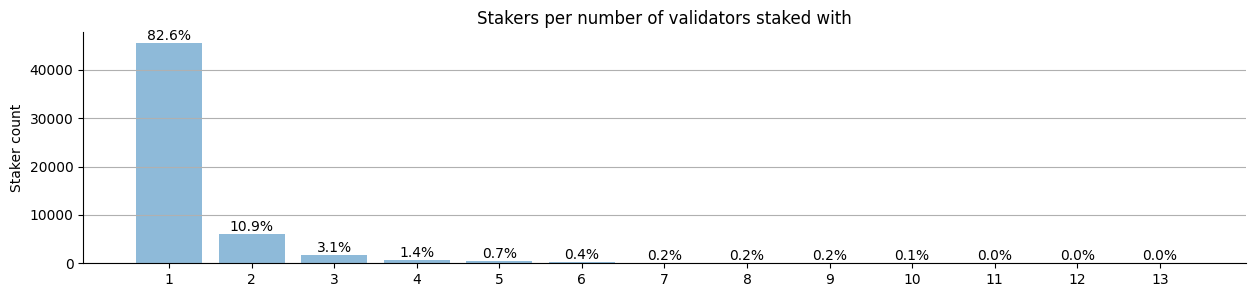

In [38]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
pos = list(range(0, len(sizes)))
ax.bar(pos, sizes, align='center', alpha=0.5)
ax.set_ylabel('Staker count')
ax.set_xticks(pos)
ax.set_xticklabels(labels)
ax.set_title('Stakers per number of validators staked with')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
for bars in ax.containers:
    ax.bar_label(bars, labels=percentages)
ax.yaxis.grid(True)
plt.rcParams["figure.figsize"] = (15,3)
plt.show()



## Conclusion

Diversification of stakers between different validators can be much improved, a simple measure is more than enough to show that the big majority of the stakers only stakes with one validator.

In order to improve diversifications I have the following suggestions:

- improve communication to educate stakers on he topic of diversification
- improve staking UI to incentivize staking with multiple validators
- adapt staking contract to only allow staking to at least 3 validators at once